# Create snow dynamics results from IMS
- Mean Snow Minimum (**smin_avg**): 205 (July 24)
- Mean Length of Winter Year (wyl_avg): 364 days
- Mean Snow Maximum (**smax_avg**): 16 (January 16)
- Mean Snow Length (slen_avg): 264 days
- Mean Snow Start (**sstart_avg**): 260 (September 17)
- First Snow Start (**sstart_first**): 248 (September 5)
- Mean Snow End (**send_avg**): 158 (June 7)
- Last Snow End (**send_last**): 166 (June 15)
- Snow Status: 0 (regular) for all winter years
- Snow Periods: 1 for all winter years

In [1]:
import polars as pl
import numpy as np
import datetime as dt

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Visualization/Utilities')
import Viz_Utils as vutil

In [2]:
%%time
df = pl.read_csv('IMS_pSnow_AlaskaSite.csv')
df = df.with_columns(pl.col('time').str.to_date())
c_cols = df.select(pl.exclude('time')).columns
df = df.with_columns(pl.col(c_cols).cast(pl.Float32)) 
df

CPU times: total: 78.1 ms
Wall time: 388 ms


time,0
date,f32
2018-01-01,100.0
2018-01-02,100.0
2018-01-03,100.0
2018-01-04,100.0
2018-01-05,100.0
…,…
2023-12-27,100.0
2023-12-28,100.0
2023-12-29,100.0


# Smooth dataframes
- 31 day median rolling window

In [4]:
%%time
df_sm = df.rolling(index_column = 'time', period = '31d', offset = '-16d').agg([pl.median(c_cols)])
df_sm

CPU times: total: 0 ns
Wall time: 1 ms


time,0
date,f32
2018-01-01,100.0
2018-01-02,100.0
2018-01-03,100.0
2018-01-04,100.0
2018-01-05,100.0
…,…
2023-12-27,100.0
2023-12-28,100.0
2023-12-29,100.0


# Find periods
From smoothed time-series

1. Snow/Ice Free Period (<1%)
2. Transitional Period (1 - 90%)
3. Snow/Ice Period (90+%)

Use weekly mode to smooth

In [6]:
%%time
# Initial periods
df_p = df_sm.with_columns(pl.when(pl.col(c_cols).is_between(1, 90, closed = 'left')).then(2).otherwise(pl.col(c_cols)).name.keep())
df_p = df_p.with_columns(pl.when(pl.col(c_cols) < 1).then(1).otherwise(pl.col(c_cols)).name.keep())
df_p = df_p.with_columns(pl.when(pl.col(c_cols) > 90 ).then(3).otherwise(pl.col(c_cols)).name.keep())

df_p = df_p.with_columns(pl.col(c_cols).cast(pl.Int8).name.keep()) # Limit dtype

# Weekly rolling mode, then fill edges
df_p = df_p.rolling(index_column = 'time', period = '7d', offset = '-4d').agg(pl.col(c_cols).mode().get(0))

df_p

CPU times: total: 31.2 ms
Wall time: 8.02 ms


time,0
date,i8
2018-01-01,3
2018-01-02,3
2018-01-03,3
2018-01-04,3
2018-01-05,3
…,…
2023-12-27,3
2023-12-28,3
2023-12-29,3


# Plot

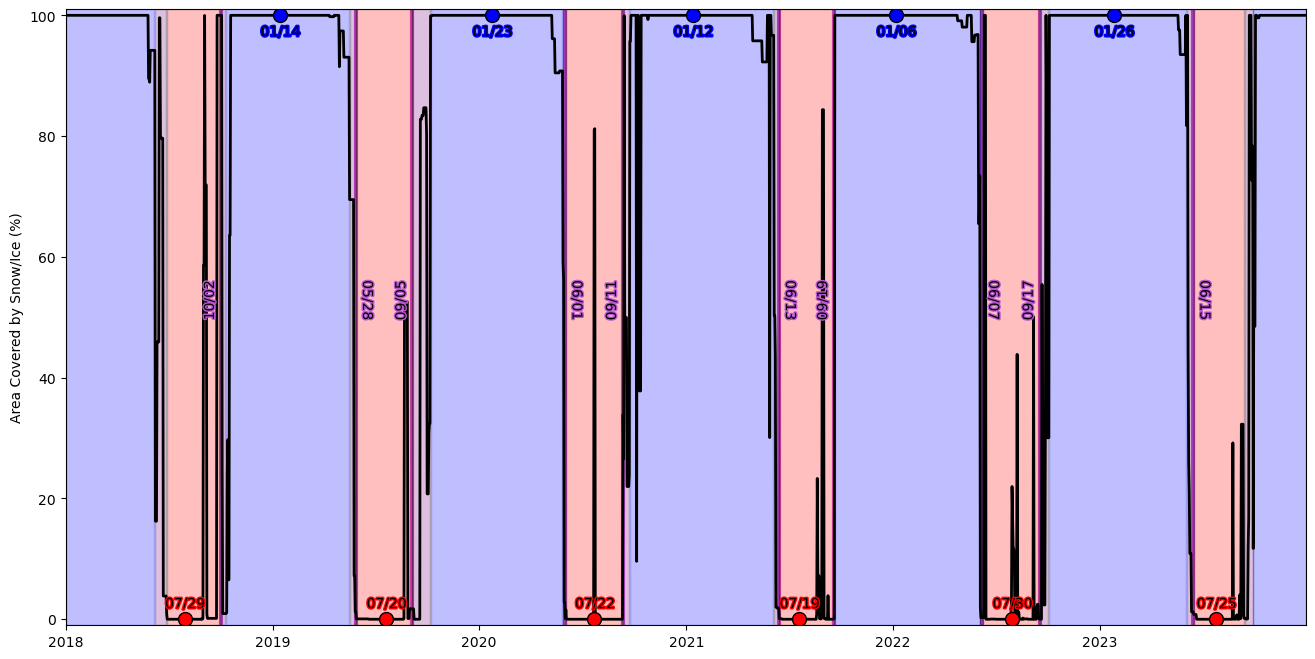

In [5]:
vutil.timeSeriesPlot(df, '0', 'ims')

# Winter Year Statistics

## Snow Minimum (Day of Year)
- Starting with smoothed time-series
- Day with least amount of snow
- If multiple days have same low amount, center day

In [6]:
# Create a dataframe to fill
df_smin = pl.DataFrame({'Year': np.unique(df_sm['time'].dt.year())})

dates = []

for year in np.unique(df_sm['time'].dt.year()): # For each year

    # Filter to year
    df_sm_y = df_sm.filter(pl.col('time').is_between(dt.date(year, 1, 1), dt.date(year, 12, 31))) 

    # Find all time-steps with minimum value and get median date
    smin = df_sm_y.with_columns(pl.when(pl.col('0') == df_sm_y.min()['0'])
                                     .then(df_sm_y.min()['0']).name.keep()).drop_nulls().median()

    # Append to dates
    dates.append(smin['time'][0].date())  

# Add column to dataframe
df_smin = df_smin.with_columns(pl.Series(name = '0', values = dates))  

df_smin 

Year,0
i32,date
2018,2018-07-29
2019,2019-07-20
2020,2020-07-22
2021,2021-07-19
2022,2022-07-30
2023,2023-07-25


In [7]:
df_smin['0'].dt.ordinal_day().mean()
# 205 = July 24

205.33333333333334

## Length of Winter Year (Days)

In [8]:
# Create a dataframe to fill
years = np.unique(df_sm['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_wyl = pl.DataFrame({'Winter': winters})

days = []

for winter in range(len(df_wyl)): # For each winter year

    # Find number of days
    days.append((df_smin['0'][winter + 1] - df_smin['0'][winter]).days) 

# Add column to dataframe
df_wyl = df_wyl.with_columns(pl.Series(name = '0', values = days))   

df_wyl

Winter,0
str,i64
"""2018-2019""",356
"""2019-2020""",368
"""2020-2021""",362
"""2021-2022""",376
"""2022-2023""",360


In [9]:
df_wyl['0'].mean()

364.4

## Snow Maximum (Day of Year)

In [10]:
# Create a dataframe to fill
years = np.unique(df_sm['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_smax = pl.DataFrame({'Winter': winters})

dates = []

for winter in range(len(df_wyl)): # For each winter year

    # Filter to winter year
    df_sm_wy = df_sm.filter(pl.col('time').is_between(df_smin['0'][winter], df_smin['0'][winter + 1],
                                                        closed = 'right')) # Day after minimum to minimum

    # Find all tme-steps with maximum value and get median date
    smax = df_sm_wy.with_columns(pl.when(pl.col('0') == df_sm_wy.max()['0'])
                                    .then(df_sm_wy.max()['0']).name.keep()).drop_nulls().median()

    # Append to dates
    dates.append(smax['time'][0].date())    
    
# Add column to dataframe
df_smax = df_smax.with_columns(pl.Series(name = '0', values = dates))   

df_smax

Winter,0
str,date
"""2018-2019""",2019-01-14
"""2019-2020""",2020-01-23
"""2020-2021""",2021-01-12
"""2021-2022""",2022-01-06
"""2022-2023""",2023-01-26


In [11]:
df_smax['0'].dt.ordinal_day().mean()
# 16 = January 16

16.2

# Snow Dynamics Statistics

## Snow Length (Days)

In [12]:
# Create a dataframe to fill
years = np.unique(df_p['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_slen = pl.DataFrame({'Winter': winters})

days = []

for winter in range(len(df_slen)): # For each winter year

    # Filter to winter year
    df_p_wy = df_p.filter(pl.col('time').is_between(df_smin['0'][winter], df_smin['0'][winter + 1],
                                                      closed = 'right')) # Day after minimum to minimum

    # Find dates classified as either transition or snow and take first date
    slen = len(df_p_wy.filter(pl.col('0') > 1))

    # Append to dates
    days.append(slen)    
    
# Add column to dataframe
df_slen = df_slen.with_columns(pl.Series(name = '0', values = days))   

df_slen

Winter,0
str,i64
"""2018-2019""",239
"""2019-2020""",271
"""2020-2021""",276
"""2021-2022""",261
"""2022-2023""",272


In [13]:
df_slen['0'].mean()

263.8

## Snow Start (Date) - Initial

In [14]:
# Create a dataframe to fill
years = np.unique(df_p['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_sstart = pl.DataFrame({'Winter': winters})

dates = []

for winter in range(len(df_sstart)): # For each winter year

    # Filter to winter year
    df_p_wy = df_p.filter(pl.col('time').is_between(df_smin['0'][winter], df_smin['0'][winter + 1],
                                                      closed = 'right')) # Day after minimum to minimum

    # Find dates classified as either transition or snow and take first date
    sstart = df_p_wy.filter(pl.col('0') > 1)[0]['time'][0]

    # Append to dates
    dates.append(sstart)    
    
# Add column to dataframe
df_sstart = df_sstart.with_columns(pl.Series(name = '0', values = dates))   

df_sstart

Winter,0
str,date
"""2018-2019""",2018-10-02
"""2019-2020""",2019-09-05
"""2020-2021""",2020-09-11
"""2021-2022""",2021-09-20
"""2022-2023""",2022-09-17


In [15]:
df_sstart['0'].dt.ordinal_day().mean()
# 260 = September 17

260.2

## Snow End (Date) - Initial

In [16]:
# Create a dataframe to fill
years = np.unique(df_p['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_send = pl.DataFrame({'Winter': winters})

dates = []

for winter in range(len(df_send)): # For each winter year

    # Filter to winter year
    df_p_wy = df_p.filter(pl.col('time').is_between(df_smin['0'][winter], df_smin['0'][winter + 1],
                                                      closed = 'right')) # Day after minimum to minimum

    # Find dates classified as either transition or snow and take last date
    send = df_p_wy.filter(pl.col('0') > 1)[-1]['time'][0]

    # Append to dates
    dates.append(send)    
    
# Add column to dataframe
df_send = df_send.with_columns(pl.Series(name = '0', values = dates))   

df_send

Winter,0
str,date
"""2018-2019""",2019-05-28
"""2019-2020""",2020-06-01
"""2020-2021""",2021-06-13
"""2021-2022""",2022-06-07
"""2022-2023""",2023-06-15


In [17]:
df_send['0'].dt.ordinal_day().mean()
# 158 = June 7

157.8

## Snow Status
0. Regular Snow Fall and Melt (All other scenarios)
1. Perennial Snow (Snow Length = Winter Year Length)
2. Inconsistent Perennial Snow (Snow Start = Winter Year Start OR Snow End Winter Year End)
3. Snow Free (Snow Length = 0)

In [18]:
# Create a dataframe to fill
years = np.unique(df_p['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_pss = pl.DataFrame({'Winter': winters})

status = []

for winter in range(len(df_pss)): # For each winter year

    # Rank 1 Perennial (all days are snow or transition)
    if df_slen['0'][winter] == df_wyl['0'][winter]: 
        status.append(1) 

    # Rank 2 Perennial (Eiher start or end of winter year (snow minimum) are snow or transition)
    elif ((df_sstart['0'][winter] == df_smin['0'][winter] + dt.timedelta(1)) | 
         ((df_send['0'][winter] == df_smin['0'][winter + 1]))):
        status.append(2)    

    # Rank 4 Snow Free
    elif df_slen['0'][winter] == 0:
        status.append(3)

    # Not perennial (All other)
    else:
        status.append(0)

# Add column to dataframe
df_pss = df_pss.with_columns(pl.Series(name = '0', values = status)) 

df_pss

Winter,0
str,i64
"""2018-2019""",0
"""2019-2020""",0
"""2020-2021""",0
"""2021-2022""",0
"""2022-2023""",0


In [19]:
np.unique(df_pss['0'], return_counts = True)

(array([0]), array([5]))

## Snow Start (Date) - Cleaned
- Perennial snow years removed
- Snow Free years already removed during initial calculation

When Snow Status = 0, carry over statistics, otherwise remove

In [20]:
df_sstart = df_pss.with_columns(pl.when(pl.col('0') == 0).then(df_sstart.get_column('0')).otherwise(None).name.keep())
df_sstart

Winter,0
str,date
"""2018-2019""",2018-10-02
"""2019-2020""",2019-09-05
"""2020-2021""",2020-09-11
"""2021-2022""",2021-09-20
"""2022-2023""",2022-09-17


In [28]:
# sstart_first
df_sstart['0'].dt.ordinal_day().min()

248

## Snow End (Date) - Cleaned
- Perennial snow years removed
- Snow Free years already removed during initial calculation

In [21]:
df_send = df_pss.with_columns(pl.when(pl.col('0') == 0).then(df_send.get_column('0')).otherwise(None).name.keep())
df_send

Winter,0
str,date
"""2018-2019""",2019-05-28
"""2019-2020""",2020-06-01
"""2020-2021""",2021-06-13
"""2021-2022""",2022-06-07
"""2022-2023""",2023-06-15


In [27]:
# send_last
df_send['0'].dt.ordinal_day().max()

166

## Snow Periods (Count)

In [22]:
# Create a dataframe to fill
years = np.unique(df_p['time'].dt.year())

winters = []

for winter in range(len(years) - 1):
   winters.append(str(years[winter]) + '-' + str(years[winter + 1]))

df_per = pl.DataFrame({'Winter': winters})

periods = []

for winter in range(len(df_per)): # For each winter year

    # Filter to winter year
    df_p_wy = df_p.filter(pl.col('time').is_between(df_smin['0'][winter], df_smin['0'][winter + 1],
                                                      closed = 'right')) # Day after minimum to minimum

    # Calculate difference between snow cumulative sum and cumulative sum during non-snow period
    cumsum = df_p_wy.with_columns(pl.when(pl.col('0').is_between(2, 3, closed = 'both')).then(1).otherwise(0).cum_sum().name.keep())
    cumsum_ns = cumsum.with_columns(pl.when(df_p_wy.get_column('0') == 1).then(pl.col('0')).otherwise(None)
                                    .forward_fill().fill_null(0).name.keep())

    # Append to periods
    # Number of periods = number of times the difference  = 1
    periods.append((cumsum - cumsum_ns == 1)['0'].sum())
    
# Add column to dataframe
df_per = df_per.with_columns(pl.Series(name = '0', values = periods))   

df_per

Winter,0
str,i64
"""2018-2019""",1
"""2019-2020""",1
"""2020-2021""",1
"""2021-2022""",1
"""2022-2023""",1
